In [143]:
import pandas as pd
import numpy as np

songs=pd.read_csv("msdchallenge/kaggle_songs.txt", sep=" ", header=None)
users=pd.read_csv("msdchallenge/kaggle_users.txt", header=None)
#song_to_track=pd.read_csv("msdchallenge/taste_profile_song_to_tracks.txt",sep="\t",header=None)
u_s_triplets=pd.read_csv("msdchallenge/kaggle_visible_evaluation_triplets.txt", sep="\t", header=None)

valHid = pd.read_csv("EvalDataYear1MSDWebsite/year1_valid_triplets_visible.txt", sep="\t", header=None)

valVis = pd.read_csv("EvalDataYear1MSDWebsite/year1_valid_triplets_hidden.txt", sep="\t", header=None)

testVis = pd.read_csv("EvalDataYear1MSDWebsite/year1_test_triplets_visible.txt", sep="\t", header=None)

testHid = pd.read_csv("EvalDataYear1MSDWebsite/year1_test_triplets_hidden.txt", sep="\t", header=None)


songs.columns=["song_id","song_index"]
users.columns=["user_id"]
u_s_triplets.columns=["user_id","song_id","counts"]
valHid.columns = ["user_id","song_id","counts"]
valVis.columns = ["user_id","song_id","counts"]

testVis.columns=["user_id","song_id","counts"]
testHid.columns=["user_id","song_id","counts"]
print( list( valHid.user_id.unique() )==list( valVis.user_id.unique() ) ) #users same for val and test
print( list( testHid.user_id.unique() )==list( testVis.user_id.unique() ) )

True
True


In [227]:


testVis = testVis.head(10000) 
testHid = testHid.head(10000) #to accelerate following for loop 
valVis = valVis.head(2000)
valHid = valHid.head(2000)

train = pd.concat([testVis,testHid, valVis])

data = pd.concat([train, valHid, valVis])
print( data.user_id.nunique() )
print( data.song_id.nunique() )
print( valHid.user_id.nunique() )
print( valVis.user_id.nunique() )
print( testHid.user_id.nunique() )
print( testVis.user_id.nunique() )


subsongs = pd.Series( data.song_id.unique() )#.sample(frac=1/50, random_state=1)
subusers=pd.Series( data.user_id.unique() )#.sample(frac=0.2, random_state=1)
#to decrease matrix size and a random sampling, but this sampling can make matrix too sparse

895
15301
163
158
704
732


In [274]:

matrix = pd.DataFrame( np.zeros( (subusers.__len__(), subsongs.__len__()) ) )
matrix.columns=list(subsongs)
matrix.index=list(subusers)
setsongs=set(subsongs)
setusers=set(subusers)


for i in range(train.__len__()): #iloc: position based, loc: index(or column name) based
    #print(i)
    r=train.iloc[i].loc['user_id']
    c=train.iloc[i].loc['song_id']
#     if r in setusers and c in setsongs:
    matrix.loc[r].loc[c]=train.iloc[i].loc['counts']
    #log scale conversion create extremly large predictions...should not take log

In [275]:
from numpy import vectorize
import math
def getusermat(matrix, subsongs, subusers):
    vfunc = vectorize( lambda x: 0 if x==0 else 1/( math.sqrt(x) ) )
    R = matrix.values # userItem matrix R
    Rt = R.transpose()
    P = np.diag( np.sum(R, axis=1) )   #row sum as diag

    P2 = vfunc(P)

    Rt = R.transpose()
    res = P2 @ R @ Rt @ P2 @ R
    res = pd.DataFrame( res )
    res.columns=list(subsongs)
    res.index=list(subusers)
    return res
usermat = getusermat(matrix, subsongs, subusers)

In [302]:
pred=[]
for i in range( valHid.__len__() ):
    r=valHid.iloc[i].loc['user_id']
    c=valHid.iloc[i].loc['song_id']
    pred.append( usermat.loc[r].loc[c])
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = math.sqrt( mean_squared_error(pred, valHid.counts) ) #rms 50
valHid['pred'] = pred

In [338]:
from sklearn.metrics import average_precision_score
from scipy.stats import spearmanr
def getmap(df):#get mean average precision
    d={uid:[[], []] for uid in df['user_id']} #[[count], [pred]]
    for i in range( df.__len__() ):
        series = df.iloc[i]
        userid=series.loc['user_id']
        d[userid][0].append( float(series.loc['counts']) )
        d[userid][1].append( float(series.loc['pred']) )
    isum=0
    count=0
#     print(d)
    for key in d:
        #print(d[key][0], d[key][1])
        if not math.isnan( spearmanr( d[key][0], d[key][1] )[0]):# zero varianve leads to nan
          isum+=spearmanr( d[key][0], d[key][1] )[0]
          count+=1
#         else:
#           print(d[key][0], d[key][1])
            
    return count, isum/count, d.__len__()
getmap(valHid)

/Users/yzh/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yzh/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yzh/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/yzh/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/yzh/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


(89, 0.039484903852700086, 163)

In [336]:
trainPred=[]
for i in range( train.__len__() ):
    r=train.iloc[i].loc['user_id']
    c=train.iloc[i].loc['song_id']
    trainPred.append( usermat.loc[r].loc[c])
from sklearn.metrics import mean_squared_error
from math import sqrt

trainRms = math.sqrt( mean_squared_error(trainPred, train.counts) ) #train rms 750?, rms not a good metric
train['pred'] = trainPred 
getmap(train)# at least training data's average spearman R does not suck like rms

/Users/yzh/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yzh/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yzh/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/yzh/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/yzh/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


(825, 0.7625111564694461, 890)

In [334]:
train.shape

(22000, 4)

In [299]:
train

,user_id,song_id,counts,pred
0,00007a02388c208ea7176479f6ae06f8224355b3,SOAITVD12A6D4F824B,3,5.160000
1,00007a02388c208ea7176479f6ae06f8224355b3,SONZGLW12A6D4FBBC1,1,1.929246
2,00007a02388c208ea7176479f6ae06f8224355b3,SOXNWYP12A6D4FBDC4,1,1.720000
3,00007a02388c208ea7176479f6ae06f8224355b3,SOSPTOE12A6D4F938C,1,4.781512
4,00007a02388c208ea7176479f6ae06f8224355b3,SOXMOQF12A6701FB8B,1,1.923810
5,00007a02388c208ea7176479f6ae06f8224355b3,SOSMMEW12A8C134F96,2,3.440000
6,00007a02388c208ea7176479f6ae06f8224355b3,SONGABP12A8C1442D4,1,1.720000
7,00007a02388c208ea7176479f6ae06f8224355b3,SOJTNQQ12AF72A246E,2,3.440000
8,00007a02388c208ea7176479f6ae06f8224355b3,SOTNDOM12AF729CADB,1,1.720000
9,00014a76ed063e1a749171a253bca9d9a0ff1782,SORHASY12A6D4F8664,1,10.142857


[]

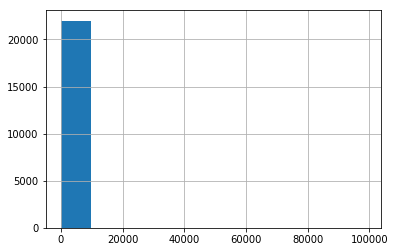

In [294]:
pd.Series( trainPred ).hist().plot()

[]

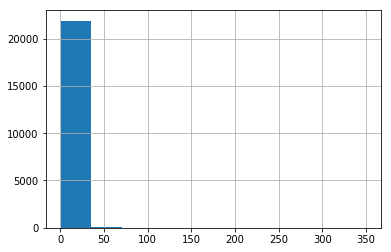

In [291]:
train.counts.hist().plot()

In [283]:
pd.Series( pred )

0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.445964
5       0.000000
6       0.000000
7       0.000000
8       0.000000
9       0.000000
10      0.000000
11      0.000000
12      0.000000
13      0.000000
14      0.000000
15      0.000000
16      0.000000
17      0.000000
18      1.413679
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
24      0.000000
25      0.070014
26      0.000000
27      0.094281
28      0.000000
29      0.094281
          ...   
1970    0.000000
1971    0.000000
1972    0.000000
1973    0.000000
1974    0.000000
1975    0.000000
1976    0.000000
1977    0.000000
1978    0.000000
1979    0.000000
1980    0.000000
1981    0.000000
1982    0.000000
1983    0.000000
1984    0.000000
1985    0.000000
1986    0.000000
1987    0.000000
1988    0.000000
1989    0.000000
1990    0.000000
1991    0.000000
1992    0.000000
1993    0.000000
1994    0.000000
1995    0.000000
1996    0.000000
1997    0.0000

In [101]:
mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},
              {'a': 100, 'b': 200, 'c': 300, 'd': 400},
              {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000 }]
df = pd.DataFrame(mydict)

In [34]:
df.index=['i', 'j', 'k']

In [82]:
u_s_triplets.shape

(1450933, 4)

In [84]:
u_s_triplets.user_id.nunique()

110000

In [93]:
u_s_triplets.groupby("rating").count()

,user_id,song_id,counts
rating,,,
0.693147,839136,839136,839136
1.098612,213712,213712,213712
1.386294,95726,95726,95726
1.609438,55158,55158,55158
1.791759,73542,73542,73542
1.945910,31902,31902,31902
2.079442,22317,22317,22317
2.197225,16179,16179,16179
2.302585,12227,12227,12227


In [106]:
from sklearn.model_selection import train_test_split
subset_train,subset_test = train_test_split(u_s_triplets, train_size=0.0001, random_state=322)

In [107]:
subset_train.shape

(145, 4)

In [111]:
subset_train.user_id.nunique()

144

In [146]:
songValue=subset_train.song_id.unique()
userValue=subset_train.user_id.unique()

In [168]:
a=[0.0]*142
b=[0.0]*144
for i in range(144):
    b[i]=a

In [169]:
R = pd.DataFrame(b)
R.columns=songValue
R.index=userValue

In [170]:
R.head()

,SOOJJCT12A6310E1C0,SOSBKKN12A8C1384B4,SOWCTEN12A58A803D4,SOZKLNO12AC468911D,SOSNQHO12A67AE0DFC,SOHGWFC12AB017F2E7,SOUSOOB12A8C13371F,SODSCIQ12AF72A0319,SOUNJIO12AB0181339,SOXPDDQ12A58A76829,...,SOZDNYH12A6D4FB7F7,SOZJCET12A6D4F7672,SOWUCTO12AB017F180,SOGRAGY12A6D4F7248,SOMFUWK12A6D4F8AFA,SOBADEB12AB018275F,SONSMUG12A58A7AEAD,SORPQKU12AB0182340,SOEETVC12A8AE4900D,SONHGBY12A8C13E762
d47be491e35346ea7fb89cc7ac748ccc1ca47db4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b568cb8cfcdd48910e729fde9568a65c4fd5b4cf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45f7879bbf47d863efa9dccb4b3e43e324ea5089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cb5ad49714a9f28f7d226248eaa278bf59ec125b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3983c4e07f43ac2c7eace01bedbc5a176f676633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
for i in range(len(subset_train)):
    r=subset_train.iloc[i]['user_id']
    c=subset_train.iloc[i]['song_id']
    R.loc[r][c]=subset_train.iloc[i]['rating']
    

In [172]:
R

,SOOJJCT12A6310E1C0,SOSBKKN12A8C1384B4,SOWCTEN12A58A803D4,SOZKLNO12AC468911D,SOSNQHO12A67AE0DFC,SOHGWFC12AB017F2E7,SOUSOOB12A8C13371F,SODSCIQ12AF72A0319,SOUNJIO12AB0181339,SOXPDDQ12A58A76829,...,SOZDNYH12A6D4FB7F7,SOZJCET12A6D4F7672,SOWUCTO12AB017F180,SOGRAGY12A6D4F7248,SOMFUWK12A6D4F8AFA,SOBADEB12AB018275F,SONSMUG12A58A7AEAD,SORPQKU12AB0182340,SOEETVC12A8AE4900D,SONHGBY12A8C13E762
d47be491e35346ea7fb89cc7ac748ccc1ca47db4,2.70805,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
b568cb8cfcdd48910e729fde9568a65c4fd5b4cf,0.00000,1.609438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45f7879bbf47d863efa9dccb4b3e43e324ea5089,0.00000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cb5ad49714a9f28f7d226248eaa278bf59ec125b,0.00000,0.000000,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3983c4e07f43ac2c7eace01bedbc5a176f676633,0.00000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
420a539d2bac99cae0ebc6d77ca51604528012c3,0.00000,0.000000,0.000000,0.000000,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
79e3e48a84047209b6836257dbaaafc5890ef28e,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.079442,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
44482483d2ae18e8121e533bab439bd33843a204,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
624dc04066a95d764694f08312c23745ad4c19bc,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.791759,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13caa75fdd2e93efd906fa9267aae8100b554e17,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.098612,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [176]:
P = np.diag(R.sum(axis=1))
Q = np.diag(R.sum(axis=0))

P_=np.diag(1/np.sqrt(R.sum(axis=1)))
Q_=np.diag(1/np.sqrt(R.sum(axis=0)))

In [179]:
Gamma_U=np.matmul(np.matmul(np.matmul(np.matmul(P_,R),R.T),P_),R)

In [180]:
Gamma_I=np.matmul(np.matmul(np.matmul(np.matmul(R,Q_),R.T),R),Q_)

In [188]:
Gamma_U.shape

(144, 142)

In [184]:
Gammu_U

NameError: name 'Gammu_U' is not defined